In [ ]:
!pip install -e git+https://github.com/inoueakimitsu/milwrap.git@ovr-classifier#egg=milwrap
!pip install -e git+https://github.com/garydoranjr/misvm.git#egg=misvm

# restart vm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining milwrap from git+https://github.com/inoueakimitsu/milwrap.git@ovr-classifier#egg=milwrap
  Updating ./src/milwrap clone (to revision ovr-classifier)
  Running command git fetch -q --tags
  Running command git reset --hard -q 6f76405d62b6e7e946cbfb066bb5d2d4ca9d499f
  Attempting uninstall: milwrap
    Found existing installation: milwrap 0.1.3
    Can't uninstall 'milwrap'. No files were found to uninstall.
  Running setup.py develop for milwrap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining misvm from git+https://github.com/garydoranjr/misvm.git#egg=misvm
  Updating ./src/misvm clone
  Running command git fetch -q --tags
  Running command git reset --hard -q b2118fe04d98c00436bdf8a0e4bbfb6082c5751c
  Attempting uninstall: misvm
    Found existing installation: misvm 1.0
    Can't uninstall 'misvm'. No files were found

In [ ]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import misvm
from milwrap.countbase import MilCountBasedMultiClassLearner, OneVsRestMilCountBasedMultiClassLearner, convert_binary_classifiers_to_ovr_multiclassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Generate synthetic dataset using zero inflated style model

def generate_class_ratios(n_classes, alpha, prob_of_non_zero):
    while True:
        # Generate class ratios using zero inflated style model
        use_classes = np.random.choice([0, 1], size=n_classes, p=[
                                       1-prob_of_non_zero, prob_of_non_zero])
        if not np.all(use_classes == 0):
            ratio_classes = use_classes * \
                np.random.dirichlet(alpha=np.ones(n_classes)*alpha, size=1)[0]
            # Avoid zero ratio classes
            if not np.all(ratio_classes == 0):
                break
    # Normalize class ratios
    ratio_classes = ratio_classes / np.sum(ratio_classes)
    return ratio_classes


def generate_instance(n_classes, n_instances_of_each_bags, alpha, prob_of_non_zero):
    class_labels_of_intance_in_bags = [np.random.choice(
        np.arange(n_classes),
        size=n_instance_in_bag,
        p=generate_class_ratios(n_classes, alpha, prob_of_non_zero)) for n_instance_in_bag in n_instances_of_each_bags]
    return class_labels_of_intance_in_bags


def generate_data(
        seed, n_classes, n_bags, n_max_instance_in_one_bag, divisions, alpha, prob_of_non_zero, n_features, x_min, x_max, cov_diag, test_size):
    """
    Generate data using generate_instance function

    Args:
        seed: int (seed for random number generator)
        n_classes: int (number of classes)
        n_bags: int (number of bags)
        n_max_instance_in_one_bag: int (maximum number of instances in one bag)
        divisions: list (divisions for number of instances in each bag)
        alpha: float (alpha for dirichlet distribution)
        prob_of_non_zero: float (probability of non-zero class ratio)
        n_features: int (number of features)
        x_min: float (minimum value of x)
        x_max: float (maximum value of x)
        cov_diag: float (diagonal covariance scale)
        test_size: float (test size for train_test_split)
    """
    np.random.seed(seed)
    n_instances_of_each_bags = [np.random.randint(
        low=1, high=n_max_instance_in_one_bag) for _ in range(n_bags)]  # low needs to be 1
    class_labels_of_instance_in_bags = generate_instance(
        n_classes, n_instances_of_each_bags, alpha=alpha, prob_of_non_zero=prob_of_non_zero)
    count_each_class_of_instance_in_bags = [pd.Series(
        x).value_counts().to_dict() for x in class_labels_of_instance_in_bags]
    count_each_class_of_instance_in_bags_matrix = pd.DataFrame(
        count_each_class_of_instance_in_bags)[list(range(n_classes))].values
    count_each_class_of_instance_in_bags_matrix = np.nan_to_num(
        count_each_class_of_instance_in_bags_matrix)
    lower_threshold = np.zeros_like(
        count_each_class_of_instance_in_bags_matrix)
    upper_threshold = np.zeros_like(
        count_each_class_of_instance_in_bags_matrix)

    for i_bag in range(n_bags):
        for i_class in range(n_classes):
            positive_count = count_each_class_of_instance_in_bags_matrix[i_bag, i_class]
            for i_division in range(len(divisions)-1):
                if divisions[i_division] <= positive_count and positive_count < divisions[i_division+1]:
                    lower_threshold[i_bag, i_class] = divisions[i_division]
                    upper_threshold[i_bag, i_class] = divisions[i_division+1]

    means_of_classes = [np.random.uniform(
        low=x_min, high=x_max, size=n_features) for _ in range(n_classes)]
    covs_of_classes = [np.eye(n_features)*cov_diag for _ in range(n_classes)]
    bags = [
        np.vstack([
            np.random.multivariate_normal(
                means_of_classes[class_label],
                covs_of_classes[class_label],
                size=1) for class_label in class_labels_of_instance_in_bag
        ]) for class_labels_of_instance_in_bag in class_labels_of_instance_in_bags
    ]

    bags_train, bags_test, lower_threshold_train, lower_threshold_test, \
        upper_threshold_train, upper_threshold_test, \
        count_each_class_of_instance_in_bags_matrix_train, \
        count_each_class_of_instance_in_bags_matrix_test, \
        class_labels_of_instance_in_bags_train, class_labels_of_instance_in_bags_test = \
        train_test_split(bags, lower_threshold, upper_threshold, count_each_class_of_instance_in_bags_matrix,
                         class_labels_of_instance_in_bags, test_size=test_size, random_state=seed)

    # return bags_train, bags_test, lower_threshold_train, lower_threshold_test, upper_threshold_train, class_labels_of_instance_in_bags_train
    return bags_train, bags_test, lower_threshold_train, lower_threshold_test, \
        upper_threshold_train, upper_threshold_test, \
        count_each_class_of_instance_in_bags_matrix_train, \
        count_each_class_of_instance_in_bags_matrix_test, \
        class_labels_of_instance_in_bags_train, class_labels_of_instance_in_bags_test


def test_mi_svm(n_classes, bags_train, bags_test, lower_threshold_train, lower_threshold_test, misvm_C, misvm_max_iters, misvm_gamma):
    classifiers_for_each_class = []
    for i_class in range(n_classes):
        # labels are -1 or 1
        labels_for_current_class_train = (
            lower_threshold_train[:, i_class] > 0.5) * 2 - 1
        classifier = misvm.miSVM(kernel='rbf', C=misvm_C,
                                 max_iters=misvm_max_iters, gamma=misvm_gamma)
        classifier.fit(bags_train, labels_for_current_class_train)
        classifiers_for_each_class.append(classifier)

    # predict on test data using trained classifiers of mi-SVM
    predicted_scores_for_each_classes_test_all_bag = []
    for i_bag in range(len(bags_test)):
        predicted_scores_for_each_classes_test = []
        for i_class in range(n_classes):
            labels_for_current_class_test = (
                (lower_threshold_test[:, i_class] > 0.5) * 2 - 1)[i_bag]
            classifier = classifiers_for_each_class[i_class]
            predicted_scores_for_each_classes_test.append(
                classifier.predict([bags_test[i_bag]], instancePrediction=True))

        predicted_labels_test = np.argmax(np.stack(
            [instance_pred for bag_pred, instance_pred in predicted_scores_for_each_classes_test], axis=1), axis=1)
        predicted_scores_for_each_classes_test_all_bag.append(
            predicted_labels_test)

    return pd.DataFrame([pd.value_counts(x)
                         for x in predicted_scores_for_each_classes_test_all_bag]).fillna(0)


def test_milwrap_multiclass(n_classes, bags_train, bags_test, lower_threshold_train, upper_threshold_train, class_labels_of_instance_in_bags_train, svm_C, max_iters, svm_gamma):

    clf = SVC(C=svm_C, probability=True, kernel='rbf', gamma=svm_gamma)
    learner = MilCountBasedMultiClassLearner(clf)
    clf_mil, _ = learner.fit(
        bags_train,
        lower_threshold_train,
        upper_threshold_train,
        n_classes,
        debug_true_y=class_labels_of_instance_in_bags_train,
        max_iter=max_iters)

    milwrap_predicted_labels_test_all_bag = []
    for i_bag in range(len(bags_test)):
        milwrap_predicted_labels_test_all_bag.append(
            clf_mil.predict(bags_test[i_bag]))
    milwrap_predicted_labels_test_all_bag

    return pd.DataFrame([pd.value_counts(x)
                         for x in milwrap_predicted_labels_test_all_bag]).fillna(0)


def test_oracle(n_classes, bags_train, bags_test, lower_threshold_train, upper_threshold_train, class_labels_of_instance_in_bags_train, svm_C, max_iters, svm_gamma):

    clf = SVC(C=svm_C, probability=True, kernel='rbf', gamma=svm_gamma)
    labels = np.hstack(class_labels_of_instance_in_bags_train)
    features = np.vstack(bags_train)
    clf.fit(features, labels)

    milwrap_predicted_labels_test_all_bag = []
    for i_bag in range(len(bags_test)):
        milwrap_predicted_labels_test_all_bag.append(
            clf.predict(bags_test[i_bag]))
    milwrap_predicted_labels_test_all_bag

    return pd.DataFrame([pd.value_counts(x)
                         for x in milwrap_predicted_labels_test_all_bag]).fillna(0)


def test_milwrap_ovr(n_classes, bags_train, bags_test, lower_threshold_train, upper_threshold_train, class_labels_of_instance_in_bags_train, svm_C, max_iters, svm_gamma):
    binary_classifiers = [SVC(C=svm_C, probability=True, kernel='rbf', gamma=svm_gamma) for _ in range(n_classes)]
    learner = OneVsRestMilCountBasedMultiClassLearner(binary_classifiers)
    binary_classifiers = learner.fit(
        bags_train,
        lower_threshold_train,
        upper_threshold_train,
        n_classes,
        max_iter=max_iters)
    
    n_features = bags_train[0].shape[1]
    clf_mil = convert_binary_classifiers_to_ovr_multiclassifier(n_classes, n_features, binary_classifiers)
        
    milwrap_predicted_labels_test_all_bag = []
    for i_bag in range(len(bags_test)):
        milwrap_predicted_labels_test_all_bag.append(
            clf_mil.predict(bags_test[i_bag]))
    milwrap_predicted_labels_test_all_bag

    return pd.DataFrame([pd.value_counts(x)
                         for x in milwrap_predicted_labels_test_all_bag]).fillna(0)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
output_path = Path("/content/drive/MyDrive/work/milwrap-man/result/n_bags=200")
output_path.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive


In [ ]:
prob_of_non_zero_list = [0.2, 0.5, 0.7, 1.0]
C_list = [0.01, 0.1, 1.0, 10.0]
gamma_list = [0.01, 0.1, 1.0, 10.0]

In [ ]:
seed = 1
n_classes = 5
n_bags = 200
n_max_instance_in_one_bag = 100
# divisions = [0, 50, 100, 200, 1000, n_max_instance_in_one_bag]
divisions = [0, 5, 10, 20, 50, n_max_instance_in_one_bag]
alpha = 1.0
n_features = 7
x_min = 0
x_max = 1
cov_diag = 0.5**2
test_size = 0.5

In [ ]:
for prob_of_non_zero in prob_of_non_zero_list:

    print("===========================================")
    print("prob_of_non_zero:", prob_of_non_zero)

    misvm_max_iters = 10
    milwrap_multiclass_max_iter = 10
    milwrap_ovr_max_iter = 10
    
    bags_train, bags_test, lower_threshold_train, lower_threshold_test, \
            upper_threshold_train, upper_threshold_test, \
            count_each_class_of_instance_in_bags_matrix_train, \
            count_each_class_of_instance_in_bags_matrix_test, \
            class_labels_of_instance_in_bags_train, class_labels_of_instance_in_bags_test = generate_data(
        seed, n_classes, n_bags, n_max_instance_in_one_bag, divisions, alpha, prob_of_non_zero, n_features, x_min, x_max, cov_diag, test_size)
    
    for gamma in gamma_list:
        print("gamma:", gamma)

        for C in C_list:
            print("C:", C)

            output_file_path = output_path / f"prob_of_non_zero={prob_of_non_zero}_C={C}_gamma={gamma}_method=misvm.csv"
            if not output_file_path.exists():
                df_mi_svm = test_mi_svm(
                    n_classes, bags_train, bags_test, lower_threshold_train, lower_threshold_test, C, misvm_max_iters, gamma)
                df_mi_svm.to_csv(output_file_path)

            output_file_path = output_path / f"prob_of_non_zero={prob_of_non_zero}_C={C}_gamma={gamma}_method=milwrapmc.csv"
            if not output_file_path.exists():
                df_milwrap_multiclass = test_milwrap_multiclass(
                    n_classes, bags_train, bags_test, lower_threshold_train, upper_threshold_train, class_labels_of_instance_in_bags_train, C, milwrap_multiclass_max_iter, gamma)
                df_milwrap_multiclass.to_csv(output_file_path)

            output_file_path = output_path / f"prob_of_non_zero={prob_of_non_zero}_C={C}_gamma={gamma}_method=milwrapovr.csv"
            if not output_file_path.exists():
                df_milwrap_ovr = test_milwrap_ovr(
                    n_classes, bags_train, bags_test, lower_threshold_train, upper_threshold_train, class_labels_of_instance_in_bags_train, C, milwrap_ovr_max_iter, gamma)
                df_milwrap_ovr.to_csv(output_file_path)

            output_file_path = output_path / f"prob_of_non_zero={prob_of_non_zero}_C={C}_gamma={gamma}_method=oracle.csv"
            if not output_file_path.exists():
                df_oracle = test_oracle(
                    n_classes, bags_train, bags_test, lower_threshold_train, upper_threshold_train, class_labels_of_instance_in_bags_train, C, milwrap_multiclass_max_iter, gamma)
                df_oracle.to_csv(output_file_path)


prob_of_non_zero: 0.2
gamma: 0.01
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 0.1
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 1.0
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 10.0
C: 0.01
C: 0.1
C: 1.0
C: 10.0
prob_of_non_zero: 0.5
gamma: 0.01
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 0.1
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 1.0
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 10.0
C: 0.01
C: 0.1
C: 1.0
C: 10.0
prob_of_non_zero: 0.7
gamma: 0.01
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 0.1
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 1.0
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 10.0
C: 0.01
C: 0.1
C: 1.0
C: 10.0
prob_of_non_zero: 1.0
gamma: 0.01
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 0.1
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 1.0
C: 0.01
C: 0.1
C: 1.0
C: 10.0
gamma: 10.0
C: 0.01
C: 0.1
C: 1.0
C: 10.0


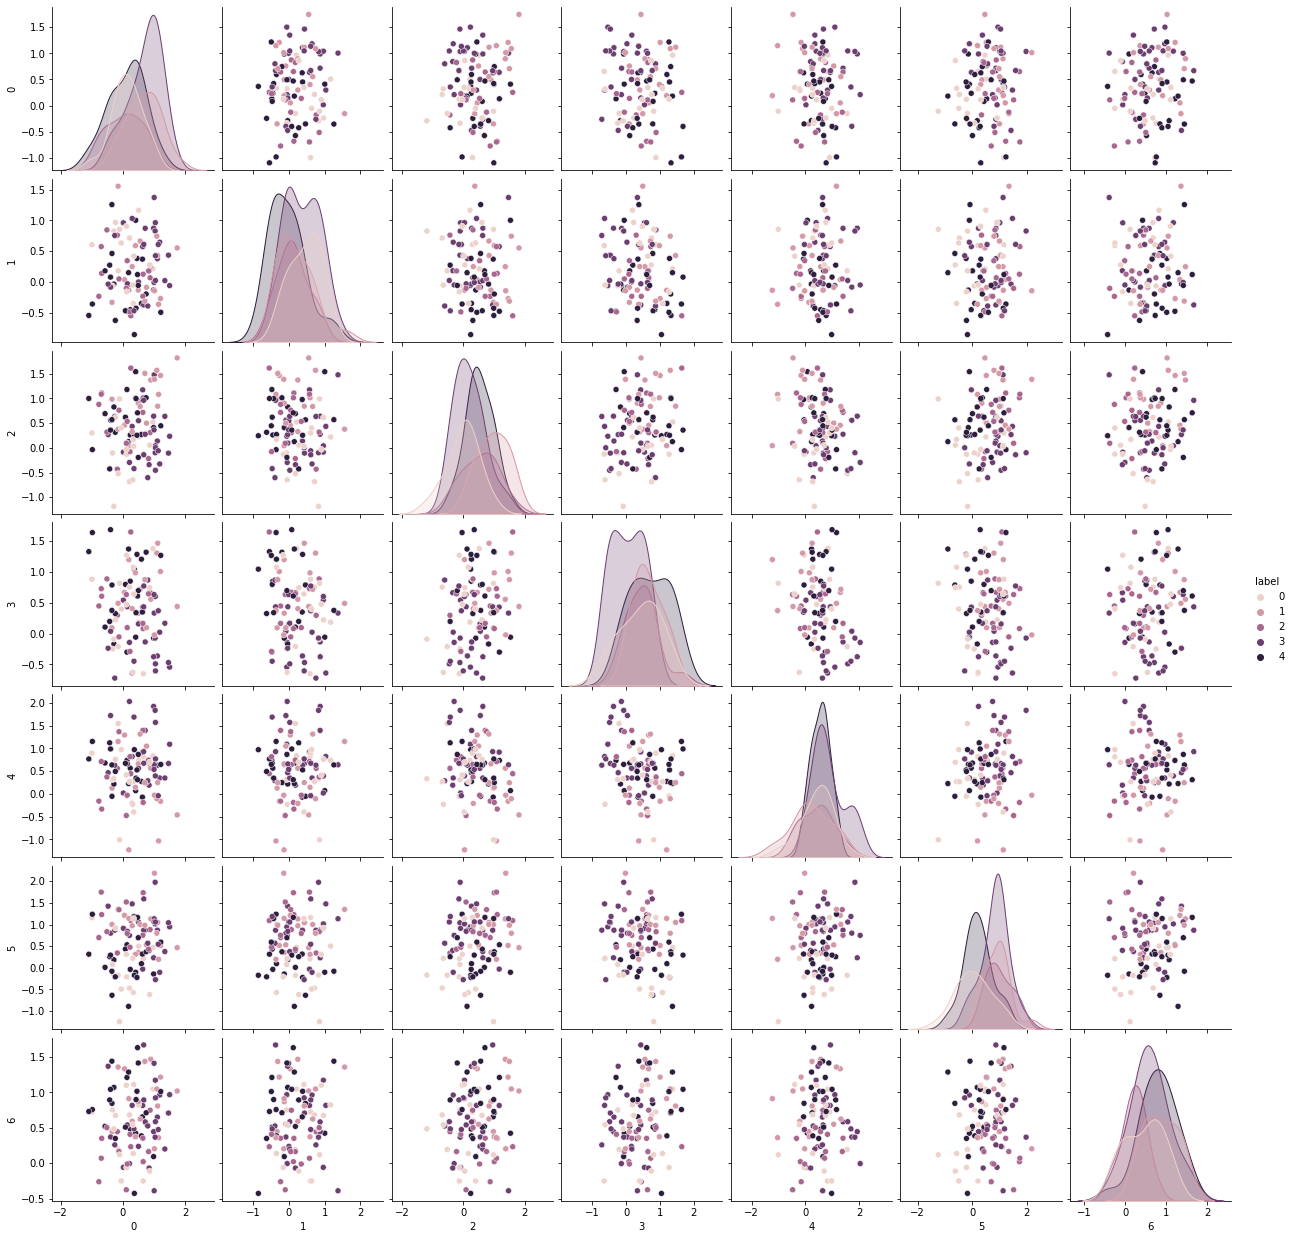

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
X = np.vstack(bags_train)
y = np.hstack(class_labels_of_instance_in_bags_train)
# plt.scatter(X[:,0], X[:,5], c=y)
df_plot = pd.DataFrame(X).assign(label=y).sample(100)
sns.pairplot(df_plot, hue="label")
# df_plot

In [ ]:
true_counts_for_each_prob_of_non_zero = {}

for prob_of_non_zero in prob_of_non_zero_list:

    bags_train, bags_test, lower_threshold_train, lower_threshold_test, \
            upper_threshold_train, upper_threshold_test, \
            count_each_class_of_instance_in_bags_matrix_train, \
            count_each_class_of_instance_in_bags_matrix_test, \
            class_labels_of_instance_in_bags_train, class_labels_of_instance_in_bags_test = generate_data(
        seed, n_classes, n_bags, n_max_instance_in_one_bag, divisions, alpha, prob_of_non_zero, n_features, x_min, x_max, cov_diag, test_size)

    true_counts_for_each_prob_of_non_zero[prob_of_non_zero] = pd.DataFrame([pd.value_counts(x) for x in class_labels_of_instance_in_bags_test]).fillna(0)


In [ ]:
import glob
import re

dfs = []

for csv_path in glob.glob(str(output_path / "*.csv")):
    #re.search(r"prob_non_zero_(\d*?)", Path(csv_path).name)
    match = re.search(r'prob_of_non_zero\=(?P<prob_of_non_zero>[\d.]*)_C\=(?P<C>[\d.]*)_gamma\=(?P<gamma>[\d.]*)_method\=(?P<method>.*?)\.csv', Path(csv_path).name)
    # print(csv_path)
    # print(match['prob_of_non_zero'])
    # print(match['C'])
    # print(match['method'])

    df = pd.read_csv(csv_path, index_col=0).fillna(0)
    df.columns = df.columns.astype(int)
    for i_class in range(n_classes):
        if i_class not in df.columns:
            df[i_class] = 0.0

    df_true = true_counts_for_each_prob_of_non_zero[float(match['prob_of_non_zero'])]
    
    df_err = df - df_true
    

    df['prob_of_non_zero'] = float(match['prob_of_non_zero'])
    df['C'] = float(match['C'])
    df['gamma'] = float(match['gamma'])
    df['method'] = match['method']
    df['RMSE'] = (df_err**2).mean(axis=1)**(1/2)
    for i_class in range(n_classes):
        if i_class in df.columns:
            df.drop([i_class], axis=1, inplace=True)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all

,prob_of_non_zero,C,gamma,method,RMSE
0,0.2,0.01,0.01,misvm,15.453155
1,0.2,0.01,0.01,misvm,1.673320
2,0.2,0.01,0.01,misvm,1.095445
3,0.2,0.01,0.01,misvm,0.632456
4,0.2,0.01,0.01,misvm,13.461055
...,...,...,...,...,...
25595,1.0,10.00,10.00,oracle,11.661904
25596,1.0,10.00,10.00,oracle,20.581545
25597,1.0,10.00,10.00,oracle,16.625282
25598,1.0,10.00,10.00,oracle,4.774935


In [ ]:
pd.set_option('display.max_rows', 500)

df_all_rmse = df_all.groupby(['prob_of_non_zero', 'method', 'C', 'gamma']).mean(['RMSE'])
df_all_rmse


RMSE
prob_of_non_zero method     C     gamma           
0.2              milwrapmc  0.01  0.01   22.369979
                                  0.10   13.917847
                                  1.00   22.369979
                                  10.00  22.369979
                            0.10  0.01   13.219985
                                  0.10    8.511750
                                  1.00    8.712120
                                  10.00  22.369979
                            1.00  0.01    8.326890
                                  0.10    8.447831
                                  1.00    8.698738
                                  10.00  13.491025
                            10.00 0.01    8.417218
                                  0.10    8.547347
                                  1.00   10.282325
                                  10.00  14.343456
                 milwrapovr 0.01  0.01   21.773168
                                  0.10   14.837277
                                  1.00   16.375742
                                  10.00  19.193990
                            0.10  0.01   10.682779
                                  0.10   15.249885
                                  1.00   16.078764
                                  10.00  19.842800
                            1.00  0.01   16.372104
                                  0.10   10.898270
                                  1.00    8.902160
                                  10.00  15.698177
                            10.00 0.01   12.712673
                                  0.10    9.377957
                                  1.00   10.377317
                                  10.00  14.998548
                 misvm      0.01  0.01    8.723563
                                  0.10    8.911692
                                  1.00   17.289855
                                  10.00  24.453478
                            0.10  0.01   25.822984
                                  0.10   25.822984
                                  1.00   25.822984
                                  10.00  25.822984
                            1.00  0.01   24.958539
                                  0.10   25.822984
                                  1.00   22.369979
                                  10.00  24.958539
                            10.00 0.01   22.369979
                                  0.10   22.369979
                                  1.00   26.785067
                                  10.00  24.921589
                 oracle     0.01  0.01   24.958539
                                  0.10   12.522143
                                  1.00   15.355219
                                  10.00  24.958539
                            0.10  0.01   10.401926
                                  0.10    8.502419
                                  1.00    8.839774
                                  10.00  24.958539
                            1.00  0.01    8.556126
                                  0.10    8.604307
                                  1.00    8.905924
                                  10.00  16.377878
                            10.00 0.01    8.536689
                                  0.10    8.713164
                                  1.00   10.104406
                                  10.00  15.584103
0.5              milwrapmc  0.01  0.01   23.164623
                                  0.10   23.164623
                                  1.00   23.164623
                                  10.00  23.164623
                            0.10  0.01   17.851336
                                  0.10    8.195503
                                  1.00    8.612977
                                  10.00  23.164623
                            1.00  0.01    8.162976
                                  0.10    8.001851
                                  1.00    8.232363
                                  10.00  16.681983
                            10.00 0.01    7.907823
                 

In [ ]:
 df_all_rmse.groupby(['prob_of_non_zero', 'method']).min('RMSE').unstack()

RMSE                                
method           milwrapmc milwrapovr      misvm    oracle
prob_of_non_zero                                          
0.2               8.326890   8.902160   8.723563  8.502419
0.5               7.879345   8.296561   8.114577  8.073404
0.7               5.630376   8.650113  22.475758  5.474190
1.0               4.167990   5.924350  20.766295  4.083704

In [ ]:
 df_all_rmse.groupby(['prob_of_non_zero', 'method']).median('RMSE').unstack()

RMSE                                 
method            milwrapmc milwrapovr      misvm     oracle
prob_of_non_zero                                            
0.2               11.751155  15.124217  24.940064  10.253166
0.5               12.895413  13.956861  23.252228  10.894608
0.7                8.469444  21.775418  22.475758   6.877347
1.0                6.907813  16.247055  20.766295   4.750985

In [ ]:
df_all.groupby(['prob_of_non_zero', 'method']).count()

C  gamma  RMSE
prob_of_non_zero method                       
0.2              milwrapmc   1600   1600  1600
                 milwrapovr  1600   1600  1600
                 misvm       1600   1600  1600
                 oracle      1600   1600  1600
0.5              milwrapmc   1600   1600  1600
                 milwrapovr  1600   1600  1600
                 misvm       1600   1600  1600
                 oracle      1600   1600  1600
0.7              milwrapmc   1600   1600  1600
                 milwrapovr  1600   1600  1600
                 misvm       1600   1600  1600
                 oracle      1600   1600  1600
1.0              milwrapmc   1600   1600  1600
                 milwrapovr  1600   1600  1600
                 misvm       1600   1600  1600
                 oracle      1600   1600  1600